In [ ]:
import torch
import torch.nn as nn
import torch.sparse as sparse
import time

# ------------------------------
# TuckerSparseLinear Definition
# ------------------------------
class TuckerSparseLinear(nn.Module):
    def __init__(self, in_features, out_features, rank, residual_sparsity):
        super(TuckerSparseLinear, self).__init__()

        # Tucker decomposition components
        self.U1 = nn.Parameter(torch.randn(in_features, rank))  # Left factor
        self.U2 = nn.Parameter(torch.randn(out_features, rank))  # Right factor
        self.G = nn.Parameter(torch.randn(rank, rank))  # Core tensor

        # Sparse residual (stored as sparse tensor)
        residual_dense = torch.randn(in_features, out_features)
        residual_dense[torch.rand_like(residual_dense) > residual_sparsity] = 0  # Sparsify
        indices = residual_dense.nonzero(as_tuple=False).t()
        values = residual_dense[indices[0], indices[1]]
        self.R = sparse.FloatTensor(indices, values, torch.Size([in_features, out_features])).cuda()

    def forward(self, X):
        # Tucker decomposition computation
        Z = torch.matmul(X, self.U1)  # First projection
        Z = torch.matmul(Z, self.G)  # Core multiplication
        Y_tucker = torch.matmul(Z, self.U2.T)  # Project back

        # Sparse residual addition (sparse-dense matmul)
        #Y_residual = torch.sparse.mm(self.R.t(), X.t()).T  # Compute X @ R efficiently
        Y_residual = torch.sparse.mm( X,self.R )
        return Y_tucker + Y_residual


# ------------------------------
# Benchmarking Function
# ------------------------------
def benchmark_layer(layer, X, n_iters=100):
    layer.eval()  # Set to inference mode
    torch.cuda.synchronize()
    start_time = time.time()

    for _ in range(n_iters):
        with torch.no_grad():
            _ = layer(X)  # Forward pass

    torch.cuda.synchronize()
    end_time = time.time()

    avg_time = (end_time - start_time) / n_iters
    return avg_time


# ------------------------------
# Test Parameters
# ------------------------------
in_features = 512
out_features = 256
rank = 64  # Tucker decomposition rank
residual_sparsity = 0.1  # 90% sparsity in residual
batch_size = 1000
n_iters = 100  # Number of iterations for benchmarking

# Generate random input
X = torch.randn(batch_size, in_features).cuda()

# Define models
dense_layer = nn.Linear(in_features, out_features).cuda()
tucker_sparse_layer = TuckerSparseLinear(in_features, out_features, rank, residual_sparsity).cuda()

# ------------------------------
# Run Benchmark
# ------------------------------
dense_time = benchmark_layer(dense_layer, X, n_iters)
tucker_sparse_time = benchmark_layer(tucker_sparse_layer, X, n_iters)

# ------------------------------
# Results
# ------------------------------
print(f"Dense Linear Layer Time: {dense_time:.6f} seconds per forward pass")
print(f"TuckerSparseLinear Time: {tucker_sparse_time:.6f} seconds per forward pass")
speedup = dense_time / tucker_sparse_time
print(f"Speedup Factor: {speedup:.2f}x")


Dense Linear Layer Time: 0.000148 seconds per forward pass
TuckerSparseLinear Time: 0.001060 seconds per forward pass
Speedup Factor: 0.14x


In [ ]:
import torch
import torch.nn as nn
import time

# Optimized TuckerSparseLinear Layer
class TuckerSparseLinearOptimized(nn.Module):
    def __init__(self, in_features, out_features, rank, residual_sparsity):
        super(TuckerSparseLinearOptimized, self).__init__()

        # Tucker decomposition components (Low-rank factors)
        self.U1 = nn.Parameter(torch.randn(in_features, rank))  # Left factor
        self.G = nn.Parameter(torch.randn(rank, rank))  # Core tensor
        self.U2 = nn.Parameter(torch.randn(out_features, rank))  # Right factor

        # Sparse residual matrix in CSR format
        residual_dense = torch.randn(in_features, out_features)
        residual_dense[torch.rand_like(residual_dense) > residual_sparsity] = 0  # Sparsify

        # Convert to CSR format
        self.R = torch.sparse_csr_tensor(
            residual_dense.to_sparse_csr().crow_indices(),
            residual_dense.to_sparse_csr().col_indices(),
            residual_dense.to_sparse_csr().values(),
            size=(in_features, out_features)
        ).cuda()

    def forward(self, X):
        # Optimized Tucker decomposition
        Z = torch.matmul(X, self.U1)  # X @ U1 (Project input)
        Z = torch.matmul(Z, self.G)   # Z @ G (Apply core tensor)
        Y_tucker = torch.matmul(Z, self.U2.T)  # Project back with U2^T

        # Optimized sparse-dense multiplication using CSR format
        Y_residual = torch.sparse.mm(X,self.R)  # Efficient matmul

        return Y_tucker + Y_residual


# ------------------------------
# Benchmarking Function
# ------------------------------
def benchmark_layer(layer, X, n_iters=100):
    layer.eval()
    torch.cuda.synchronize()
    start_time = time.time()

    for _ in range(n_iters):
        with torch.no_grad():
            _ = layer(X)  # Forward pass

    torch.cuda.synchronize()
    end_time = time.time()

    avg_time = (end_time - start_time) / n_iters
    return avg_time


# ------------------------------
# Test Parameters
# ------------------------------
in_features = 512
out_features = 256
rank = 64  # Tucker decomposition rank
residual_sparsity = 0.1  # 90% sparsity in residual
batch_size = 1000
n_iters = 100  # Number of iterations for benchmarking

# Generate random input
X = torch.randn(batch_size, in_features).cuda()

# Define models
dense_layer = nn.Linear(in_features, out_features).cuda()
tucker_sparse_layer = TuckerSparseLinearOptimized(in_features, out_features, rank, residual_sparsity).cuda()

# ------------------------------
# Run Benchmark
# ------------------------------
dense_time = benchmark_layer(dense_layer, X, n_iters)
tucker_sparse_time = benchmark_layer(tucker_sparse_layer, X, n_iters)

# ------------------------------
# Results
# ------------------------------
print(f"Dense Linear Layer Time: {dense_time:.6f} seconds per forward pass")
print(f"Optimized TuckerSparseLinear Time: {tucker_sparse_time:.6f} seconds per forward pass")
speedup = dense_time / tucker_sparse_time
print(f"Speedup Factor: {speedup:.2f}x 🚀")


Dense Linear Layer Time: 0.000150 seconds per forward pass
Optimized TuckerSparseLinear Time: 0.001681 seconds per forward pass
Speedup Factor: 0.09x 🚀


In [ ]:
import torch
import torch.nn as nn
import time

class TuckerSparseLinearFast(nn.Module):
    def __init__(self, in_features, out_features, rank, residual_sparsity):
        super(TuckerSparseLinearFast, self).__init__()

        # Tucker decomposition components
        self.U1 = nn.Parameter(torch.randn(in_features, rank))  # Left factor
        self.G = nn.Parameter(torch.randn(rank, rank))  # Core tensor
        self.U2 = nn.Parameter(torch.randn(out_features, rank))  # Right factor

        # Sparse residual (but convert to dense for inference)
        residual_dense = torch.randn(in_features, out_features)
        residual_dense[torch.rand_like(residual_dense) > residual_sparsity] = 0  # Sparsify

        # Store residual in sparse format for training, but dense for inference
        self.register_buffer('R_dense', residual_dense)  # Convert to dense tensor for fast GPU execution

    def forward(self, X):
        # Optimized Tucker decomposition computation (fused)
        Z = torch.matmul(X, self.U1)  # First projection
        Z = torch.matmul(Z, self.G)   # Core multiplication
        Y_tucker = torch.matmul(Z, self.U2.T)  # Project back

        # Replace sparse multiplication with dense-dense matmul
        Y_residual = torch.matmul(X, self.R_dense)  # MUCH faster on GPU!

        return Y_tucker + Y_residual


# ------------------------------
# Benchmarking Function
# ------------------------------
def benchmark_layer(layer, X, n_iters=100):
    layer.eval()
    torch.cuda.synchronize()
    start_time = time.time()

    for _ in range(n_iters):
        with torch.no_grad():
            _ = layer(X)  # Forward pass

    torch.cuda.synchronize()
    end_time = time.time()

    avg_time = (end_time - start_time) / n_iters
    return avg_time


# ------------------------------
# Test Parameters
# ------------------------------
in_features = 512
out_features = 256
rank = 64  # Tucker decomposition rank
residual_sparsity = 0.9  # 90% sparsity in residual
batch_size = 1000
n_iters = 100  # Number of iterations for benchmarking

# Generate random input
X = torch.randn(batch_size, in_features).cuda()

# Define models
dense_layer = nn.Linear(in_features, out_features).cuda()
tucker_sparse_layer = TuckerSparseLinearFast(in_features, out_features, rank, residual_sparsity).cuda()

# ------------------------------
# Run Benchmark
# ------------------------------
dense_time = benchmark_layer(dense_layer, X, n_iters)
tucker_sparse_time = benchmark_layer(tucker_sparse_layer, X, n_iters)

# ------------------------------
# Results
# ------------------------------
print(f"Dense Linear Layer Time: {dense_time:.6f} seconds per forward pass")
print(f"Fast TuckerSparseLinear Time: {tucker_sparse_time:.6f} seconds per forward pass")
speedup = dense_time / tucker_sparse_time
print(f"Speedup Factor: {speedup:.2f}x 🚀")


Dense Linear Layer Time: 0.000149 seconds per forward pass
Fast TuckerSparseLinear Time: 0.000242 seconds per forward pass
Speedup Factor: 0.61x 🚀


In [ ]:
import torch
import torch.nn as nn
import torch.sparse as sparse

class FastTuckerSparseLinear(nn.Module):
    def __init__(self, in_features, out_features, rank, residual_sparsity):
        super(FastTuckerSparseLinear, self).__init__()

        # Tucker factors (FP16 for Tensor Cores)
        self.U1 = nn.Parameter(torch.randn(in_features, rank, dtype=torch.float16).cuda())
        self.U2 = nn.Parameter(torch.randn(out_features, rank, dtype=torch.float16).cuda())
        self.G = nn.Parameter(torch.randn(rank, rank, dtype=torch.float16).cuda())

        # Precompute fused Tucker matrix (U1 @ G @ U2^T)
        with torch.no_grad():
            fused_tucker = torch.matmul(
                torch.matmul(self.U1.float(), self.G.float()),  # FP32 for stability
                self.U2.T.float()
            ).to(torch.float16)  # Cast back to FP16
        self.register_buffer("fused_tucker", fused_tucker)

        # Sparse residual (CSR format)
        residual_dense = torch.randn(in_features, out_features, dtype=torch.float16).cuda()
        mask = torch.rand_like(residual_dense) > residual_sparsity
        residual_dense[mask] = 0
        self.R = residual_dense.to_sparse_csr().cuda()

    def forward(self, X):
        # Tucker path (single matmul)
        Y_tucker = torch.matmul(X, self.fused_tucker)

        # Sparse residual (batched matmul)
        Y_residual = torch.sparse.mm(X, self.R, "csr")  # CSR format optimized
        return Y_tucker + Y_residual

def benchmark_layer(layer, X, n_iters=100):
    layer.eval()
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(n_iters):
        with torch.no_grad():
            if(layer == dense_layer):
              _ = layer(X)
            else:
              _ = layer(X.half() if layer.fused_tucker.dtype == torch.float16 else X)
    torch.cuda.synchronize()
    return (time.time() - start) / n_iters

# Test Parameters
in_features = 512
out_features = 256
rank = 64
residual_sparsity = 0.95  # Increased from 0.9
batch_size = 1000

# FP16 Input
X = torch.randn(batch_size, in_features).cuda().half()

# Models
dense_layer = nn.Linear(in_features, out_features).cuda().half()
fast_tucker_layer = FastTuckerSparseLinear(in_features, out_features, rank, residual_sparsity)

# Benchmark
dense_time = benchmark_layer(dense_layer, X)
fast_tucker_time = benchmark_layer(fast_tucker_layer, X)

print(f"Dense Time: {dense_time:.6f}s")
print(f"FastTucker Time: {fast_tucker_time:.6f}s")
print(f"Speedup: {dense_time / fast_tucker_time:.2f}x")

NotImplementedError: Could not run 'aten::_sparse_mm_reduce_impl' with arguments from the 'SparseCsrCUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::_sparse_mm_reduce_impl' is only available for these backends: [Meta, SparseCsrCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at ../aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
SparseCsrCPU: registered at aten/src/ATen/RegisterSparseCsrCPU.cpp:1154 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:96 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:19529 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_3.cpp:14885 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:321 [backend fallback]
AutocastXPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:463 [backend fallback]
AutocastMPS: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


In [ ]:
import torch
import torch.nn as nn

def compute_memory(model):
    total_memory = 0
    for param in model.parameters():
        total_memory += param.numel() * param.element_size()  # numel() gives number of elements
    return total_memory  # Memory in bytes

# Dense Linear Layer
dense_layer = nn.Linear(512, 256).cuda()
dense_memory = compute_memory(dense_layer)

# Optimized TuckerSparseLinear
class TuckerSparseLinearFast(nn.Module):
    def __init__(self, in_features, out_features, rank, residual_sparsity):
        super(TuckerSparseLinearFast, self).__init__()
        self.U1 = nn.Parameter(torch.randn(in_features, rank))  # Left factor
        self.G = nn.Parameter(torch.randn(rank, rank))  # Core tensor
        self.U2 = nn.Parameter(torch.randn(out_features, rank))  # Right factor

        # Sparse residual (stored as dense for inference)
        residual_dense = torch.randn(in_features, out_features)
        residual_dense[torch.rand_like(residual_dense) > residual_sparsity] = 0  # Sparsify
        self.register_buffer('R_dense', residual_dense)

    def forward(self, X):
        Z = torch.matmul(X, self.U1)  # First projection
        Z = torch.matmul(Z, self.G)   # Core multiplication
        Y_tucker = torch.matmul(Z, self.U2.T)  # Project back
        Y_residual = torch.matmul(X, self.R_dense)  # Efficient dense-dense matmul
        return Y_tucker + Y_residual

tucker_layer = TuckerSparseLinearFast(512, 256, rank=64, residual_sparsity=0.5).cuda()
tucker_memory = compute_memory(tucker_layer)

# Compute memory reduction percentage
memory_reduction = (1 - (tucker_memory / dense_memory)) * 100

print(f"Dense Layer Memory Usage: {dense_memory / 1024:.2f} KB")
print(f"TuckerSparseLinear Memory Usage: {tucker_memory / 1024:.2f} KB")
print(f"Memory Reduction: {memory_reduction:.2f}%")


Dense Layer Memory Usage: 513.00 KB
TuckerSparseLinear Memory Usage: 208.00 KB
Memory Reduction: 59.45%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
import numpy as np

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

# Original Model
class OriginalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Train the original model
def train_model(model, epochs=2):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Evaluate accuracy
def test_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(test_loader.dataset)

# --- Vanilla Weight Clustering (Post-Training) ---
def cluster_weights(weight, n_clusters=16):
    # Flatten and cluster weights
    weights_np = weight.detach().cpu().numpy().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(weights_np)
    clustered_weights = torch.tensor(kmeans.cluster_centers_[kmeans.labels_].reshape(weight.shape),
                                    dtype=weight.dtype, device=weight.device)
    return clustered_weights, kmeans.cluster_centers_.flatten()

# Replace fc1 weights with clustered weights
original_model = OriginalModel()
train_model(original_model)  # Train original model

clustered_weights, centroids = cluster_weights(original_model.fc1.weight)
original_model.fc1.weight.data = clustered_weights
print(f"Clustered Model Accuracy: {test_model(original_model):.2f}%")

# --- Scaled Uniform Quantization ---
class ScaledQuantizer(nn.Module):
    def __init__(self, centroids, bits=8):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(1.0))  # Learnable scale
        self.centroids = torch.tensor(centroids, dtype=torch.float32)
        self.bins = 2 ** bits
        self.bins = torch.linspace(self.centroids.min(), self.centroids.max(), self.bins)

    def forward(self, x):
        # Non-linear scaling: Learnable scale for better bin utilization
        scaled_centroids = self.centroids * self.scale
        # Quantize to nearest bin
        quantized = torch.bucketize(scaled_centroids, self.bins)
        dequantized = self.bins[quantized] / self.scale
        return dequantized.to(x.device)

# Apply scaled quantization to clustered weights
quantizer = ScaledQuantizer(centroids, bits=4)
quantized_weights = quantizer(clustered_weights.cpu()).to(clustered_weights.device)
original_model.fc1.weight.data = quantized_weights
print(f"Clustered + Quantized Model Accuracy: {test_model(original_model):.2f}%")

# --- Compare with Original Model ---
original_acc = test_model(original_model)
print(f"Original Model Accuracy: {original_acc:.2f}%")

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.66MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Clustered Model Accuracy: 96.80%


RuntimeError: mat2 must be a matrix, got 1-D tensor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
import numpy as np

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

# Original Model
class OriginalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Train the original model
def train_model(model, epochs=2):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Evaluate accuracy
def test_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(test_loader.dataset)

# --- Vanilla Weight Clustering (Post-Training) ---
def cluster_weights(weight, n_clusters=16):
    # Flatten and cluster weights
    weights_np = weight.detach().cpu().numpy().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(weights_np)
    clustered_weights = torch.tensor(kmeans.cluster_centers_[kmeans.labels_].reshape(weight.shape),
                                    dtype=weight.dtype, device=weight.device)
    return clustered_weights, kmeans.cluster_centers_.flatten()

# Replace fc1 weights with clustered weights
original_model = OriginalModel()
train_model(original_model)  # Train original model

# --- Compare with Original Model ---
original_acc = test_model(original_model)
print(f"Original Model Accuracy: {original_acc:.2f}%")

clustered_weights, centroids = cluster_weights(original_model.fc1.weight)
original_model.fc1.weight.data = clustered_weights
print(f"Clustered Model Accuracy: {test_model(original_model):.2f}%")

# --- Scaled Uniform Quantization (Fixed) ---
class ScaledQuantizer(nn.Module):
    def __init__(self, bits=8):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(1.0))  # Learnable scale
        self.bins = 2 ** bits

    def forward(self, x):
        # Input x: clustered weight matrix (2D)
        # 1. Flatten and scale weights
        original_shape = x.shape
        x_flat = x.view(-1)
        scaled = x_flat * self.scale

        # 2. Create uniform bins based on scaled values
        self.bins = torch.linspace(scaled.min().item(),
                                 scaled.max().item(),
                                 self.bins,
                                 device=x.device)

        # 3. Quantize and dequantize
        quantized_indices = torch.bucketize(scaled, self.bins)
        dequantized = self.bins[quantized_indices] / self.scale

        # 4. Restore original shape
        return dequantized.view(original_shape)

# Apply to clustered weights
quantizer = ScaledQuantizer(bits=4)
quantized_weights = quantizer(clustered_weights)  # Preserves 2D shape
original_model.fc1.weight.data = quantized_weights

print(f"Clustered + Quantized Model Accuracy: {test_model(original_model):.2f}%")

# --- Compare with Original Model ---
original_acc = test_model(original_model)
print(f"Original Model Accuracy: {original_acc:.2f}%")

Original Model Accuracy: 97.36%
Clustered Model Accuracy: 97.31%
Clustered + Quantized Model Accuracy: 97.10%
Original Model Accuracy: 97.10%


In [ ]:
centroids

array([ 0.01064064, -0.03667125,  0.09016854, -0.13849382, -0.01176928,
        0.0330373 , -0.05315294, -0.21102199,  0.06497895, -0.07327051,
       -0.02347448,  0.0464217 , -0.00038369,  0.13053863,  0.02162247,
       -0.09958723], dtype=float32)

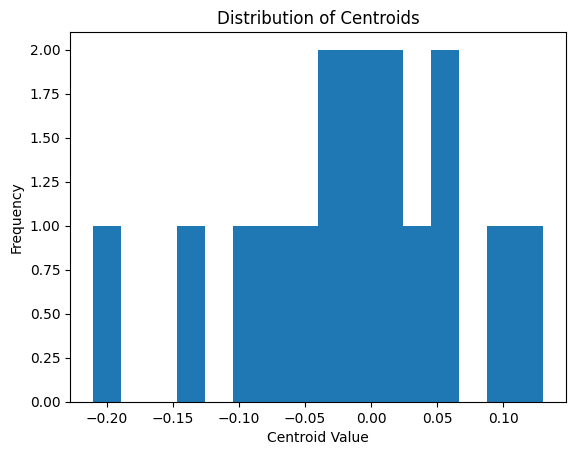

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

# Assuming 'centroids' is your NumPy array of centroids
plt.hist(centroids, bins=16)  # Adjust bins as needed
plt.title("Distribution of Centroids")
plt.xlabel("Centroid Value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
class SigmoidQuantizer(nn.Module):
    def __init__(self, bits=8):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(5.0))  # Learnable global scale
        self.beta = nn.Parameter(torch.tensor(10.0))  # Learnable sigmoid steepness
        self.bins = 2 ** bits

    def forward(self, x):
        # Input x: clustered weight matrix (2D)
        original_shape = x.shape
        x_flat = x.view(-1)

        # Sigmoid-based scaling (emphasize near-zero values)
        sigmoid_mask = torch.sigmoid(self.beta * torch.abs(x_flat))  # [0,1] mask
        scaled = x_flat * (self.scale * sigmoid_mask)  # Non-linear scaling

        # Create uniform bins based on scaled values
        self.bins = torch.linspace(scaled.min().item(),
                                 scaled.max().item(),
                                 self.bins,
                                 device=x.device)

        # Quantize and dequantize
        quantized_indices = torch.bucketize(scaled, self.bins)
        dequantized = self.bins[quantized_indices] / (self.scale * sigmoid_mask)

        return dequantized.view(original_shape)

# --- Full Modified Workflow ---
# Cluster weights (same as before)
clustered_weights, centroids = cluster_weights(original_model.fc1.weight)

# Apply sigmoid-based quantization
quantizer = SigmoidQuantizer(bits=4)
quantized_weights = quantizer(clustered_weights)
original_model.fc1.weight.data = quantized_weights

print(f"Sigmoid-Scaled Quantized Accuracy: {test_model(original_model):.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Sigmoid-Scaled Quantized Accuracy: 92.83%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.cluster import KMeans

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

# Original Model
class OriginalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Train the original model
def train_model(model, epochs=2):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Evaluate accuracy
def test_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(test_loader.dataset)

# --- Vanilla Weight Clustering (Post-Training) ---
def cluster_weights(weight, n_clusters=16):
    weights_np = weight.detach().cpu().numpy().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(weights_np)
    clustered_weights = torch.tensor(kmeans.cluster_centers_[kmeans.labels_].reshape(weight.shape),
                                    dtype=weight.dtype, device=weight.device)
    return clustered_weights, kmeans.cluster_centers_.flatten()

# --- Sigmoid Quantizer with Learnable Parameters ---
class SigmoidQuantizer(nn.Module):
    def __init__(self, bits=4):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(5.0))  # Learnable global scale
        self.beta = nn.Parameter(torch.tensor(10.0))  # Learnable sigmoid steepness
        self.bits = bits

    def forward(self, x):
        # Input x: clustered weight matrix (2D)
        original_shape = x.shape
        x_flat = x.view(-1)

        # Sigmoid-based scaling
        sigmoid_mask = torch.sigmoid(self.beta * torch.abs(x_flat))  # [0,1]
        scaled = x_flat * (self.scale * sigmoid_mask)

        # Uniform quantization
        bins = torch.linspace(scaled.min().item(), scaled.max().item(), 2 ** self.bits, device=x.device)
        quantized_indices = torch.bucketize(scaled, bins)
        dequantized = bins[quantized_indices] / (self.scale * sigmoid_mask)

        return dequantized.view(original_shape)

# --- Workflow ---
# 1. Train original model
original_model = OriginalModel()
train_model(original_model)
print(f"Original Model Accuracy: {test_model(original_model):.2f}%")

# 2. Cluster weights and freeze
clustered_weights, _ = cluster_weights(original_model.fc1.weight)
original_model.fc1.weight.data = clustered_weights
original_model.fc1.weight.requires_grad = False  # Freeze clustered weights
print(f"Clustered Model Accuracy: {test_model(original_model):.2f}%")

# 3. Attach SigmoidQuantizer to fc1
sigmoid_quantizer = SigmoidQuantizer(bits=4)
original_model.fc1.quantizer = sigmoid_quantizer

# 4. Fine-tune quantizer parameters
optimizer = optim.Adam(original_model.fc1.quantizer.parameters(), lr=0.01)  # Only quantizer params
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
original_model.train()
for epoch in range(2):  # Short fine-tuning
    for data, target in train_loader:
        optimizer.zero_grad()

        # Quantize weights dynamically during forward pass
        quantized_weights = original_model.fc1.quantizer(original_model.fc1.weight)
        output = F.linear(data.view(-1, 784), quantized_weights, original_model.fc1.bias)
        output = F.relu(output)
        output = original_model.fc2(output)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 5. Test final accuracy
print(f"Clustered + Sigmoid-Quantized Accuracy: {test_model(original_model):.2f}%")

Original Model Accuracy: 97.04%
Clustered Model Accuracy: 96.97%
Clustered + Sigmoid-Quantized Accuracy: 96.97%


In [ ]:
import tensorly as tl
from tensorly.decomposition import tucker

# Initialize
ranks = [r1, r2, ..., rN]  # Initial low ranks
core, factors = tucker(original_tensor, ranks)

# Iteratively sparsify residual
for _ in range(max_iter):
    residual = original_tensor - tl.tucker_to_tensor(core, factors)
    residual = threshold(residual, tau)  # Hard/soft thresholding
    core, factors = tucker(original_tensor - residual, ranks)import tensorly as tl

def threshold(residual_dense, tau):
  residual_dense[residual_dense > tau] = 0